In [38]:
from typing import Annotated, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode , tools_condition
from langgraph.graph.message import add_messages, AnyMessage
from langchain_core.messages import AIMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate
from langchain.tools import tool
from IPython.display import display, Image
from dotenv import load_dotenv

import os

load_dotenv()  # Load environment variables from .env file
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [44]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


def python_llm(requirements:str):
    """
    Generates Python code based on user requirements.
    Args:
        requirements (str): The user's requirements for the Python code.
    Returns:
        str: The generated Python code.
    """
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
    prompt = ChatPromptTemplate.from_messages({
        ("system", "You are a helpful assistant that writes Python code. return only the code for the requirements in the conversation, do not include any explanations."),
        ("user", "{requirements}")
    })
    chain = prompt | llm
    response = chain.invoke({ "requirements" : requirements })
    return response.content


def js_llm(requirements:str):
    """Generates Typescript code based on user requirements.
    Args:
        requirements (str): The user's requirements for the Typescript code.
    Returns:
        str: The generated Typescript code.
    """
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
    prompt = ChatPromptTemplate.from_messages({
        ("system", "You are a helpful assistant that writes Typescript code. return only the code for the requirements in the conversation, do not include any explanations."),
        ("user", "{requirements}")
    })
    chain = prompt | llm
    response = chain.invoke({ "requirements" : requirements })
    return response.content


def start_chat(state: State):
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
    tools = [python_llm, js_llm]
    llm_with_tools = llm.bind_tools(tools)
    
    return { "messages": llm_with_tools.invoke(state["messages"]) }

In [ ]:
tools = [python_llm, js_llm]

E0000 00:00:1762000480.350948     805 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


E0000 00:00:1762000480.350948     805 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


''

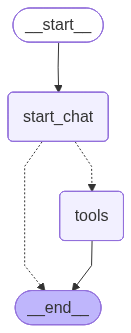

In [45]:
graph = StateGraph(State)
graph.add_node("start_chat", start_chat)
graph.add_node("tools", ToolNode(tools))



graph.add_edge(START, "start_chat")
graph.add_conditional_edges("start_chat", tools_condition)
graph.add_edge("tools",END)
graph.add_edge("start_chat",END)

graph_builder = graph.compile()


display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [46]:
results = graph_builder.invoke({
    "messages": [
        {"role": "user", "content": "I want to create a function that takes a list of numbers and returns the sum of all even numbers in the list in python"}
    ]
})
for message in results["messages"]:
   message.pretty_print()

E0000 00:00:1762001224.245263     805 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1762001227.143551   16680 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1762001227.143551   16680 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


================================ Human Message =================================

I want to create a function that takes a list of numbers and returns the sum of all even numbers in the list in python
================================== Ai Message ==================================
Tool Calls:
  python_llm (f039a483-f917-4e36-9e66-d10a9c52dd6a)
 Call ID: f039a483-f917-4e36-9e66-d10a9c52dd6a
  Args:
    requirements: Create a function that takes a list of numbers and returns the sum of all even numbers in the list.
================================= Tool Message =================================
Name: python_llm

```python
def sum_even_numbers(numbers):
    total = 0
    for num in numbers:
        if num % 2 == 0:
            total += num
    return total
```
